# Experimental Cosmology

In this notebook, we will gain a taste of what it is like to work in an experimental cosmology lab setting. Of course, working remotely renders this exercise a rough approximation of the truth; however, there is still quite a lot we can do! 

As you will see in the other notebooks, working in Python is integral to cosmological analysis. But it also plays a major role in lab: we take a lot of intermediate data, from validating hardware, to recording the temperatures inside our cryostat over time. And being able to work with that data is just as important to achieving our ultimate science goals as the final scientific analysis coming from the telescope. 

You'll mainly be *applying* your knowledge of Python here; the aim of this notebook is to give you a sense of what a laboratory-based Python analysis might look like, since some of you will be working on more "experimental" projects this summer!

# Characterizing Detectors

The Cosmic Microwave Microwave (CMB) background is cold (you will learn why if you don't already know!). Like, really cold: its blackbody temperature is only ~2.7 K above absolute zero. And the anisotropies in the CMB are ~ 4 orders of magnitude smaller: about 100 uK! Cold things are dim of course, and so Simons Observatory (and any CMB observatory) must be capable of measuring changes on the order of 1/10,000th of a really dim thing.

To do this, we employ "Transition Edge Sensing" bolometers, or TES sensors, for short. Unlike the technology you'll find in an optical camera sensor, TESs are *extremely* sensitive to what we would ordinarily consider to be "small" amounts of radiation. You'll learn more about our detectors and the details of how they work during the crash course lectures, but here we consider a particular experiment we like to run on them: an optical efficiency measurement. 

We'll work up to the final analysis, but a lot of the code will be filled in by you! And there are *no right answers* -- you should do what you feel makes the most sense, or that you feel comfortable coding. As always, if you need any help, from specific questions to ideas, reach out to the #help_desk channel on the slack!

In order to perform this measurement, we use what's called a "cold load." A cold load is basically a blackbody *at microwave wavelengths* that fits into our cryostat and sits next to our detectors when we test them. If you want to learn more about them, check out [this paper](https://arxiv.org/pdf/1711.04841.pdf) from one of our predecessor experiments, ACT. Most of the authors are now SO scientists!

The cold load is reasonably large compared to the detector "beam" (the solid angle of the sphere that a detector is sensitive to, kind of like the direction a camera lens points), and sits pretty close to the detectors too, so we can assume here that our detectors can *only* see the cold load in this lab setup. We'll start by modeling the cold load, then we'll work up to modeling the power incident on the detector, and finally we'll perform the full measurement.

Before we get started, let's get our Google drives available in Colab:

In [ ]:
# Authenticate with your gmail account
# Run this cell, click on the link, authenticate with your gmail account,
# copy the link provided after authentication and paste it below
from google.colab import drive
drive.mount('/content/drive')

And import necessary modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import quad as integrate
from scipy.constants import c, h, k

# Speed of light (SI units)
print(c)

# Planck constant (SI units)
print(h)

# Boltzmann constant (SI units)
print(k)

299792458.0
6.62607015e-34
1.380649e-23


# Modeling a Blackbody

The cold load emits perfect blackbody radiation at whatever temperature we set it to, usually somewhere between 5 K and 25 K. We should probably write a function that spits out the Planck radiation formula, $$B(\nu, T) = \frac{2h\nu^3}{c^2}\frac{1}{e^\left({\frac{h\nu}{kT}}\right) - 1}$$:

In [8]:
# The spectral radiance of a blackbody at a frequency v and temperature T
def B(v, T):
    # your code here
    

The units of this equation are fairly important: the power per unit area per unit solid angle per unit frequency emitted by the blackbody. 

Our detectors are optimized to work in frequency ranges from ~30 GHz to ~300 GHz. In fact, we have three "flavors" of detector, one for each frequency range. "LF" detectors are optimized for ~30 GHz. "MF" detectors are optimized for ~100 GHz. And "UHF" detectors (the "U" is for "ultra") are optimized for ~300 GHz. Let's plot what the blackbody spectrum emitted by our cold load looks like at a few different temperatures, as a function of frequency:

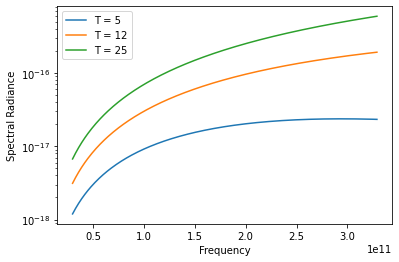

In [12]:
# Make a plot of B(v, T) at each T 
T = [5, 12, 25]

# The plot should be a function of frequency
# Units are Hertz, hence the "e9", which is the Python way of writing scientific notation
v = np.arange(30e9, 330e9, 1e9)

# Fill an array or arrays with the spectral radiance B(v, T)
# at each T across all frequencies v

# your code here - fill it in!
spectra = np.zeros(...)

# Add in the correct code instead of the dashes
for i in range(len(T)):
    spectra[i] = --------
    
# Plot your results
for i in range(len(T)):
    plt.plot(v, spectra[i], label = f'T = {T[i]}')

# Clean up the figure
plt.xlabel("Frequency")
plt.ylabel("Spectral Radiance")
plt.yscale("log")
plt.legend()
plt.show()

This graph shows the spectra radiance emitted by the cold load as a function of frequency at several temperatures! Notice how when the cold load warms from 5 K to 25 K, the emount of power it emits via radiation goes up by *a lot*. 

# Calculating Incident Power

The end goal of this experimentis to measure optical power with the detectors, and compare that to what we expect. Because the units of the spectral radiance are power per area per solid angle per hertz, in principle we will have to integrate over 3 separate variables to just get power out in the end. Fortunately, two of these integrals -- over solid angle and area -- are easy. Let's throw them in now.



# Measuring Optical Efficiency